In [2]:
import os
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [3]:
DATASET_ROOT = "/kaggle/input/asl-alphabet"

TRAIN_DIR = f"{DATASET_ROOT}/asl_alphabet_train/asl_alphabet_train"
TEST_DIR = f"{DATASET_ROOT}/asl_alphabet_test/asl_alphabet_test"
IMG_SIZE = (200, 200)
BATCH_SIZE = 32
print(os.listdir(DATASET_ROOT))


['asl_alphabet_test', 'asl_alphabet_train']


In [9]:
print(TRAIN_DIR)


/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train


In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=42
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    seed=42
)

# ✅ Extract class names BEFORE caching/prefetching
class_names = train_ds.class_names
print("Classes:", class_names)

# Now it's safe to prefetch
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.


I0000 00:00:1763371202.978882      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [13]:
def extract_label(filename):
    # Handle special classes
    fname = os.path.basename(filename).lower()
    if "nothing" in fname:
        return "nothing"
    if "space" in fname:
        return "space"
    if "del" in fname:
        return "del"
    # Otherwise, first letter
    letter = re.sub(r"[^a-z]", "", fname)[0].upper()
    return letter

test_labels = [extract_label(fname) for fname in test_files]

class_to_index = {c: i for i, c in enumerate(class_names)}
test_indices = [class_to_index[x] for x in test_labels]

def load_test_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.efficientnet.preprocess_input(img)  # <-- use correct preprocessing
    return img, label

test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_indices))
test_ds = test_ds.map(load_test_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [14]:
print(test_labels)

['A', 'E', 'L', 'N', 'S', 'D', 'G', 'I', 'W', 'M', 'nothing', 'X', 'H', 'Q', 'C', 'T', 'P', 'V', 'Y', 'U', 'space', 'O', 'B', 'R', 'F', 'Z', 'J', 'K']


In [6]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(*IMG_SIZE, 3)
)
base_model.trainable = False

inputs = layers.Input(shape=(*IMG_SIZE, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 29)             │        37,149 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,086,720 (15.59 MB)

 Trainable params: 37,149 (145.11 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [7]:
# Stage 1 checkpoint — before fine-tuning
checkpoint_stage1 = ModelCheckpoint(
    "stage1_best_model.keras",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)

early_stop_stage1 = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

# Stage 2 checkpoint — fine tuning
checkpoint_stage2 = ModelCheckpoint(
    "best_asl_model.keras",  # final best model
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)

early_stop_stage2 = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

In [8]:
EPOCHS = 8

print("\n----- STAGE 1: Training Top Layers -----\n")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_stage1, early_stop_stage1]
)

# Save **final state** after Stage 1
model.save("stage1_final_model.keras")

print("\nStage 1 training completed!")
print("✓ stage1_best_model.keras saved")
print("✓ stage1_final_model.keras saved")



----- STAGE 1: Training Top Layers -----

Epoch 1/8


E0000 00:00:1763371253.704946      48 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1763371256.004694     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 134s 56ms/step - accuracy: 0.5452 - loss: 1.8004 - val_accuracy: 0.9165 - val_loss: 0.3606
Epoch 2/8
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 110s 51ms/step - accuracy: 0.8239 - loss: 0.6688 - val_accuracy: 0.9424 - val_loss: 0.2329
Epoch 3/8
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 110s 51ms/step - accuracy: 0.8536 - loss: 0.5216 - val_accuracy: 0.9447 - val_loss: 0.1953
Epoch 4/8
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 110s 50ms/step - accuracy: 0.8654 - loss: 0.4572 - val_accuracy: 0.9544 - val_loss: 0.1653
Epoch 5/8
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 110s 51ms/step - accuracy: 0.8721 - loss: 0.4249 - val_accuracy: 0.9598 - val_loss: 0.1442
Epoch 6/8
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 109s 50ms/step - accuracy: 0.8787 - loss: 0.3964 - val_accuracy: 0.9586 - val_loss: 0.1416
Epoch 7/8
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 110s 51ms/step - accuracy: 0.8778 - loss: 0.3888 - val_accuracy: 0.9625 - val_loss: 0.1300
Epoch 8/8
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 111s 51ms/step - accuracy: 0.8827 - loss: 0.3


Stage 1 training completed!
✓ stage1_best_model.keras saved
✓ stage1_final_model.keras saved


In [9]:
print("\n----- STAGE 2: Fine-Tuning Last 40 Layers -----\n")

# Load best Stage 1 model for fine-tuning
model.load_weights("stage1_best_model.keras")

base_model.trainable = True

# Freeze all but the last 40 layers
for layer in base_model.layers[:-40]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[checkpoint_stage2, early_stop_stage2]
)

print("\nFine-tuning completed!")
print("✓ Final best model saved as best_asl_model.keras")


----- STAGE 2: Fine-Tuning Last 40 Layers -----

Epoch 1/5


E0000 00:00:1763372187.593931      48 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 157s 65ms/step - accuracy: 0.9062 - loss: 0.3017 - val_accuracy: 0.9925 - val_loss: 0.0230
Epoch 2/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 139s 64ms/step - accuracy: 0.9816 - loss: 0.0558 - val_accuracy: 0.9967 - val_loss: 0.0088
Epoch 3/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 140s 64ms/step - accuracy: 0.9893 - loss: 0.0311 - val_accuracy: 0.9980 - val_loss: 0.0058
Epoch 4/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 140s 64ms/step - accuracy: 0.9928 - loss: 0.0209 - val_accuracy: 0.9983 - val_loss: 0.0039
Epoch 5/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 139s 64ms/step - accuracy: 0.9940 - loss: 0.0160 - val_accuracy: 0.9986 - val_loss: 0.0042

Fine-tuning completed!
✓ Final best model saved as best_asl_model.keras


In [15]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.0000 - loss: 8.8296e-06
Test Accuracy: 1.0


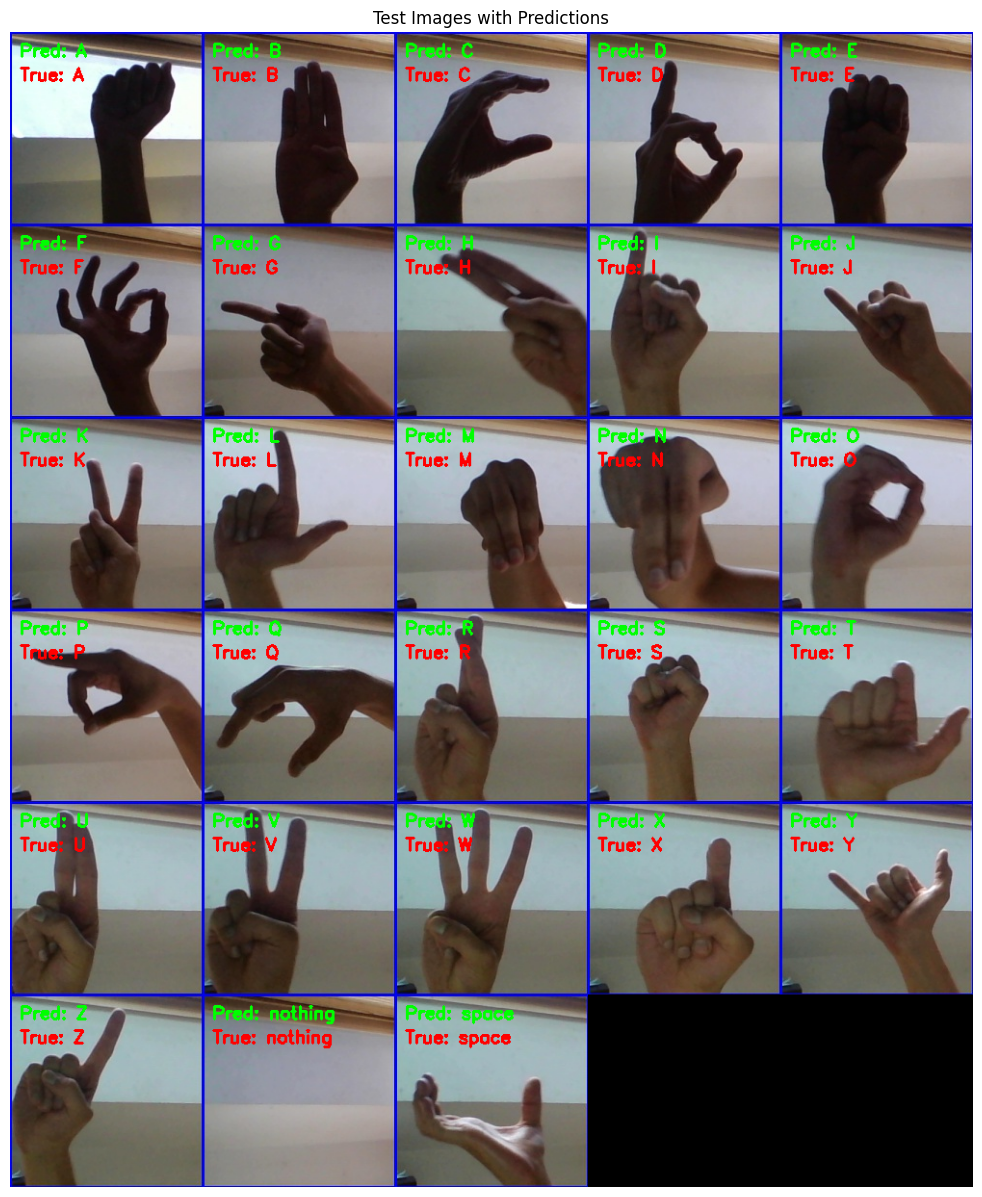


Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%


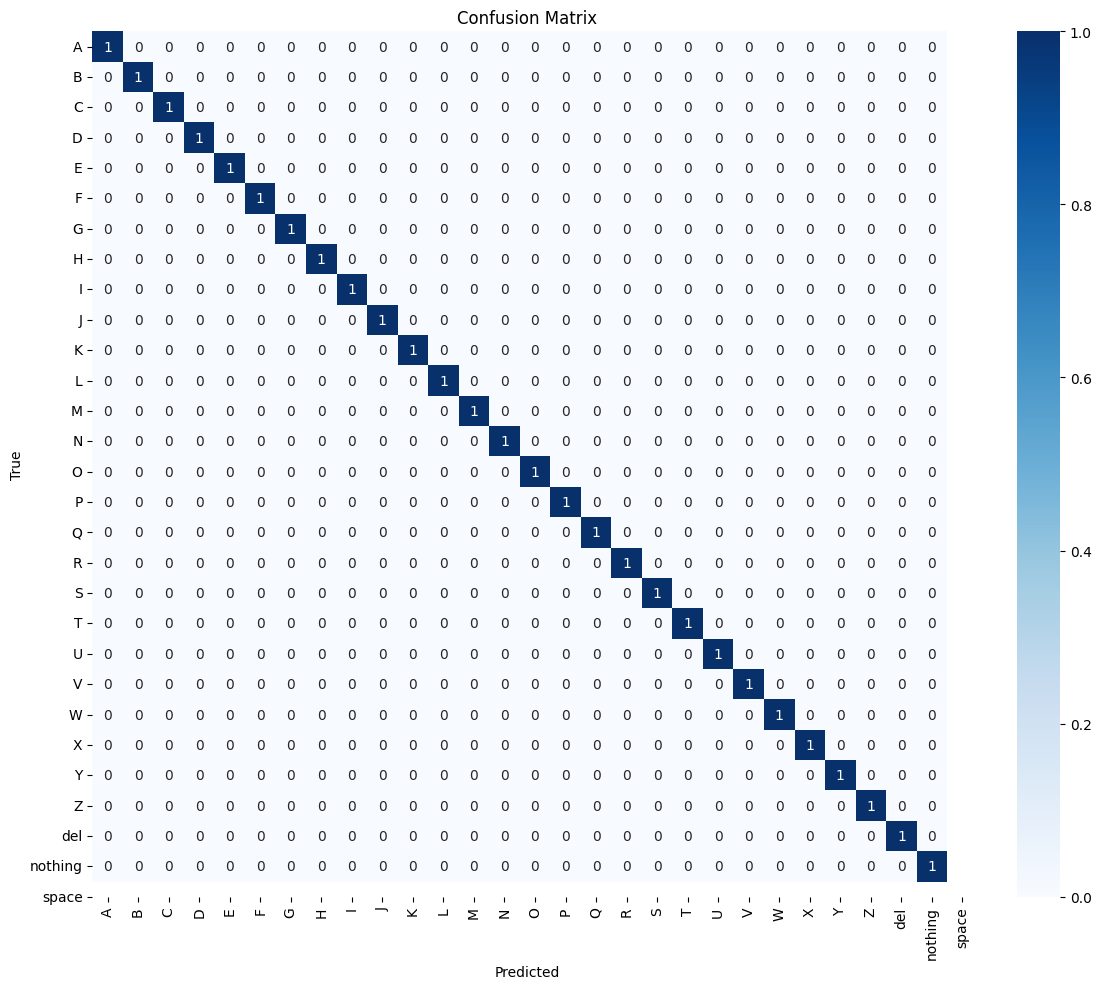

In [38]:
import cv2
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

IMG_SIZE = (200, 200)

# -----------------------------
# Load your model
# -----------------------------
model = tf.keras.models.load_model("best_asl_model.keras")

CLASS_NAMES = [
    'A', 'B', 'C', 'D', 'E', 'F', 'G',
    'H', 'I', 'J', 'K', 'L', 'M', 'N',
    'O', 'P', 'Q', 'R', 'S', 'T', 'U',
    'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space'
]

# -----------------------------
# Test folder
# -----------------------------
TEST_DIR = "/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test"

# -----------------------------
# Helper functions
# -----------------------------
def preprocess(img):
    img = cv2.resize(img, IMG_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

def get_label_from_filename(filename):
    fname = filename.lower()
    if "nothing" in fname:
        return CLASS_NAMES.index("nothing")
    if "space" in fname:
        return CLASS_NAMES.index("space")
    letter = re.sub(r"[^A-Za-z]", "", filename)[0].upper()
    return CLASS_NAMES.index(letter)

# -----------------------------
# Run predictions and prepare grid
# -----------------------------
y_true, y_pred = [], []
grid_images = []

for filename in sorted(os.listdir(TEST_DIR)):
    filepath = os.path.join(TEST_DIR, filename)
    img = cv2.imread(filepath)
    if img is None:
        continue

    label_true = get_label_from_filename(filename)
    img_input = preprocess(img)
    pred_probs = model.predict(img_input, verbose=0)
    label_pred = np.argmax(pred_probs)

    y_true.append(label_true)
    y_pred.append(label_pred)

    # Overlay predicted and true class
    display_img = cv2.resize(img, IMG_SIZE)
    cv2.putText(display_img, f"Pred: {CLASS_NAMES[label_pred]}", (10, 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    cv2.putText(display_img, f"True: {CLASS_NAMES[label_true]}", (10, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    display_img = cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB)
    grid_images.append(display_img)

# -----------------------------
# Create grid image
# -----------------------------
def make_image_grid(images, grid_size=(6, 5), img_size=IMG_SIZE):
    rows, cols = grid_size
    h, w = img_size
    grid = np.zeros((h*rows, w*cols, 3), dtype=np.uint8)

    for idx, img in enumerate(images):
        r = idx // cols
        c = idx % cols
        if r < rows and c < cols:
            grid[r*h:(r+1)*h, c*w:(c+1)*w, :] = img
    return grid

grid_img = make_image_grid(grid_images, grid_size=(6, 5))
plt.figure(figsize=(15,15))
plt.imshow(grid_img)
plt.axis("off")
plt.title("Test Images with Predictions")
plt.show()

# Save grid image
cv2.imwrite("asl_test_grid.png", cv2.cvtColor(grid_img, cv2.COLOR_RGB2BGR))

# -----------------------------
# Metrics
# -----------------------------
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
cm = confusion_matrix(y_true, y_pred)

print(f"\nAccuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")

# -----------------------------
# Confusion Matrix Heatmap
# -----------------------------
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("asl_confusion_matrix.png")
plt.show()


In [29]:
model.save("asl_final_model.keras")